<a href="https://colab.research.google.com/github/jtvon/2025-spring-B2/blob/main/Milestone_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values.

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [129]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.**

For a detailed description of the dataset features, please refer to  **Appendix 1** below.

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split.

In [ ]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data;
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:**

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


The objective of this project is to develop a predictive model that estimates the assessed tax value of residential properties influenced by its property features. It provides a data-driven estimate that helps to improve the accuracy and efficiency of property tax assessments and supports pricing decisions, negotiations, and market analysis. The model could also predict features that are most important in property valuation.

**1.2:**  How will your solution be used?


The model will be used to automate and support property assessment by providing consistent, scalable estimates of assessed tax value based on property features. Identify what features equate to higher property value (ex. If Neighborhood is more important, which neighborhoods have higher property value. This can influence consruction in different parts of the neighborhood/city/county.)

**1.3:**  How should success (or failure) be measured?


Technical Success/Measure: Success will be measured by a low RMSE, a high R-squared value (ideally above 0.8), and strong prediction consistency, reflected in a low standard deviation of RMSE.

Business Success/Measure: Model is accurate and consistent at predicting property value, efficient on hardware and time requirements. Modular and dynamic towards new data.

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process.
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [ ]:
# !pip install itables

In [ ]:
from itables import show
show(df.head())

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [ ]:
df.nunique().sort_values(ascending = True)

,0
decktypeid,1
pooltypeid7,1
pooltypeid2,1
pooltypeid10,1
poolcnt,1
hashottuborspa,1
taxdelinquencyflag,1
storytypeid,1
fireplaceflag,1
assessmentyear,1


#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

In [ ]:
# hashottuborspa , propertycountylandusecode, propertyzoningdesc , fireplaceflag, taxdelinquencyflag

**2.A.1 Answer.** Categorical features are hashottuborspa, propertycountylandusecode, propertyzoningdesc, fireplaceflag, taxdelinquencyflag.

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly.

In [ ]:
# fips, latitude, longitude, propertycountylandusecode, regionidcity, county, neightborhood. Location based features do not have any meanful impact towards pricing of property.

**2.A.2 Answer.** Features that are useless for the business purpose: fips, latitude, longitude, propertycountylandusecode, regionidcity, county, neightborhood. **Location based features do not have any meanful impact towards pricing of property.**

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example.

In [ ]:
# from hw 4
def show_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)

    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')

    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values,
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)

    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name                  # Nulls      Null %     Type')
        print('------------                  -------      ------     ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<30} {row['# Null Values']:<11} {row['Null %']:.2f}%   {row['Type']}")

show_null_counts_features(df)

The dataset contains 77613 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
buildingclasstypeid            77598       99.98%   Numeric
finishedsquarefeet13           77571       99.95%   Numeric
basementsqft                   77563       99.94%   Numeric
storytypeid                    77563       99.94%   Numeric
yardbuildingsqft26             77543       99.91%   Numeric
fireplaceflag                  77441       99.78%   Categorical
architecturalstyletypeid       77406       99.73%   Numeric
typeconstructiontypeid         77390       99.71%   Numeric
finishedsquarefeet6            77227       99.50%   Numeric
pooltypeid10                   77148       99.40%   Numeric
decktypeid                     76999       99.21%   Numeric
poolsizesum                    76744       98.88%   Numeric
pooltypeid2                    76539       98.62%   Numeric
hashottuborspa                 76074       98.02%   Categoric

In [ ]:
# i would disqualify any features that have more than 50,000 nulls (2/3 missing data)
# all features that are about 66% missing are hard to impute so I would prefer to drop those.
# buildingclasstypeid appears about 20 times out of the 76,000 samples so it is meanless to use that.


In [ ]:
# a census tract is a relatively small, permanent geographic area, often considered a neighborhood,
# with boundaries typically following visible features like roads or rivers,
# while a census block is the smallest geographic area for which the Census Bureau collects data,
# usually bounded by streets or other visible features
# do not think it is used to evalutate property price

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example.

In [ ]:
# I am skeptical on propertylandusetypeid, but it can be used for catagorical analysis.
# calculatedbathnbr looks like bathroomcnt.
# unit count is a building with a seperate living quarter within the structure.  Any nan can be converted to 0


### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

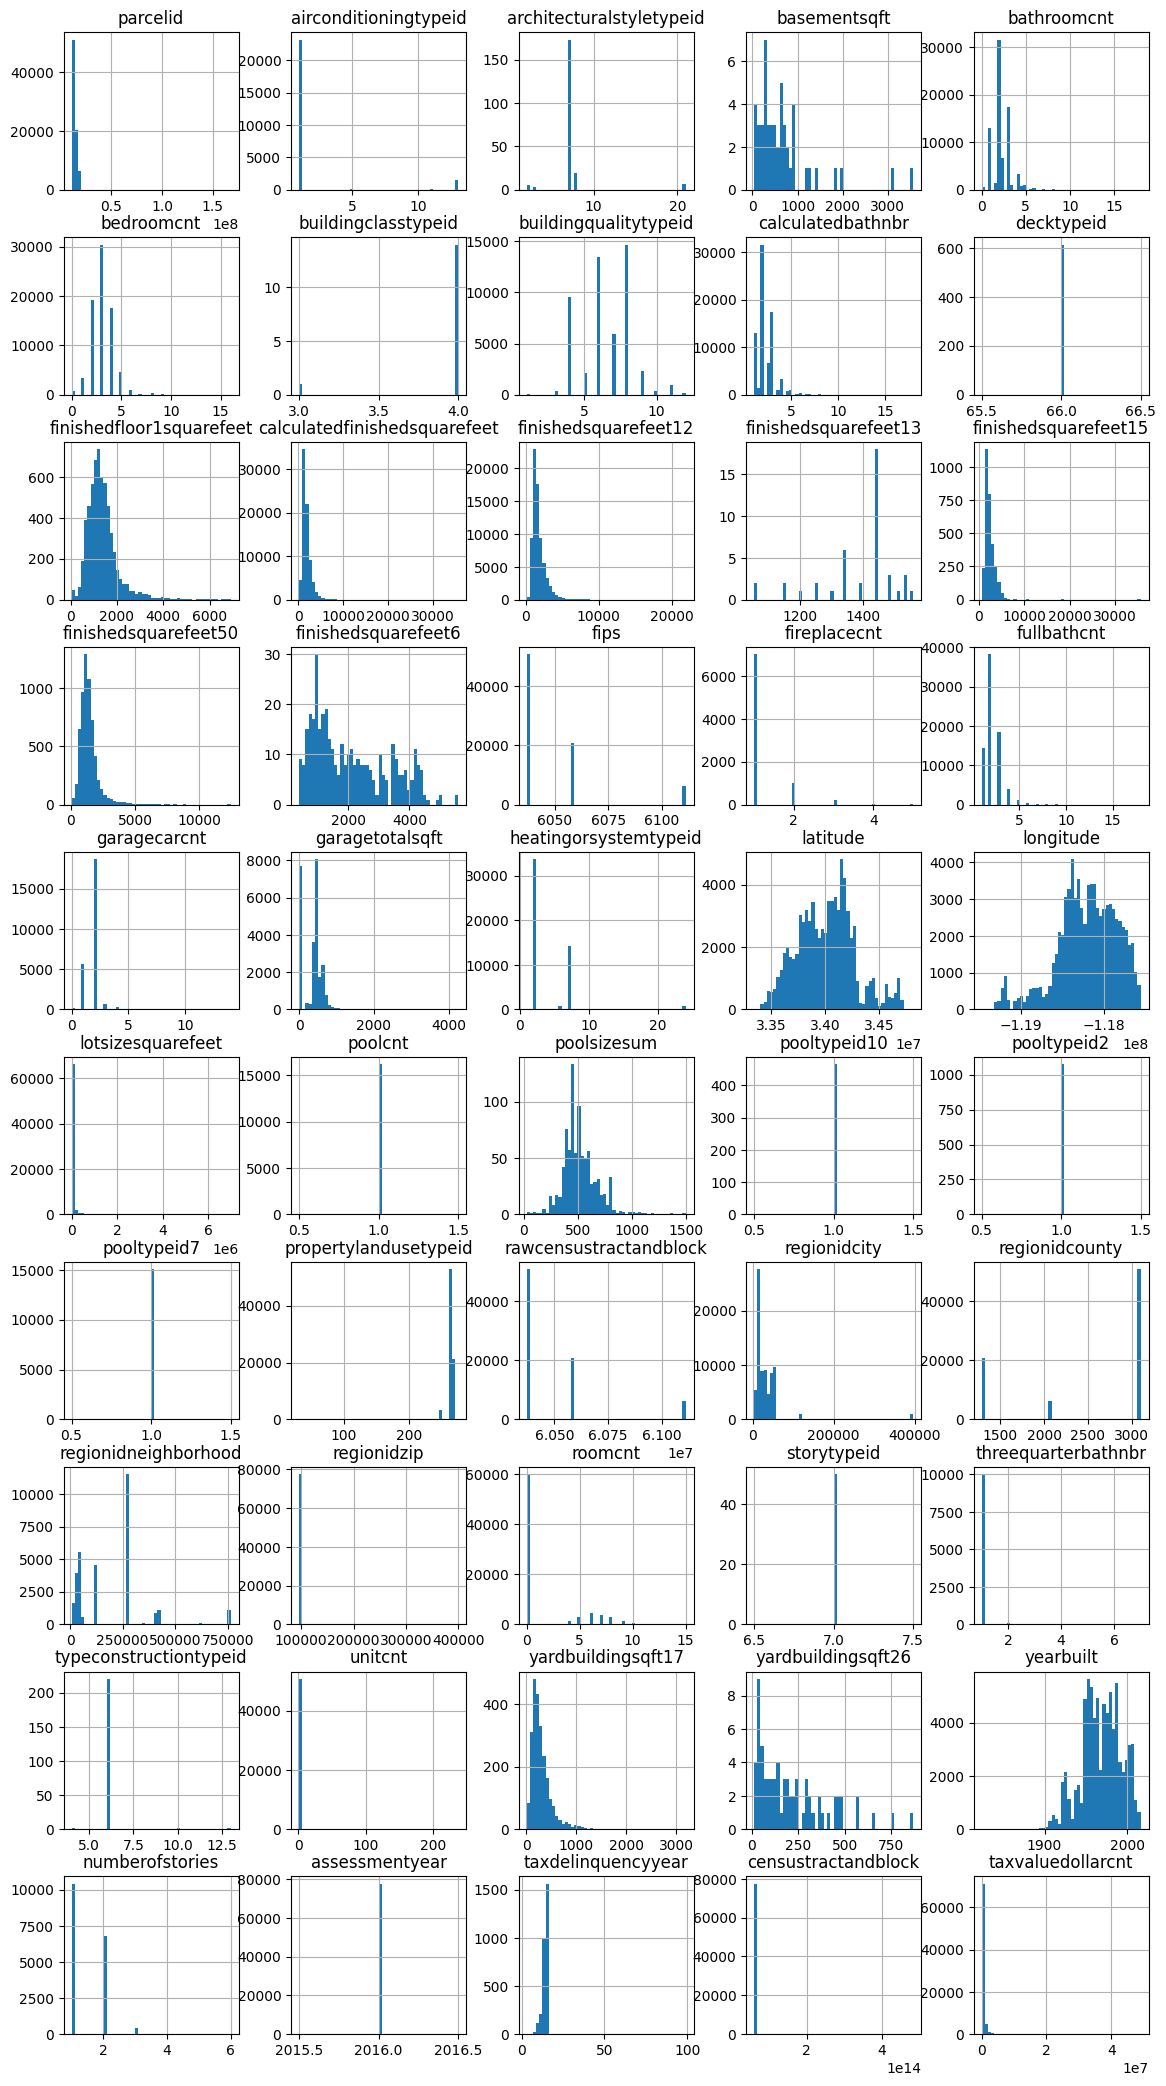

In [ ]:
# Histogram for all variables
df.hist(figsize = (14,26), bins = 50, layout = (-1, 5));

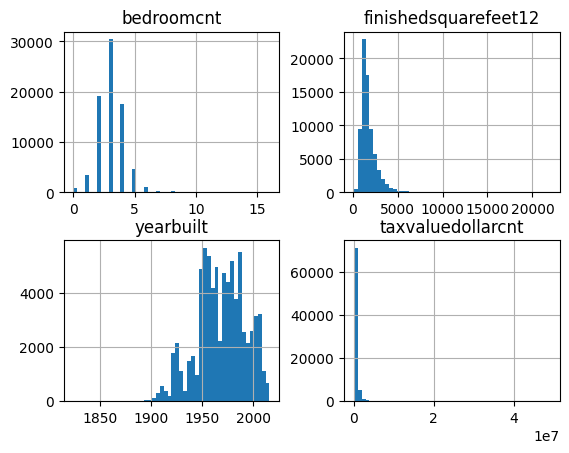

In [ ]:
# Histogram for selected features and target
selected_feature_target = ['bedroomcnt', 'finishedsquarefeet12', 'yearbuilt', 'taxvaluedollarcnt']
df[selected_feature_target].hist(bins = 50);

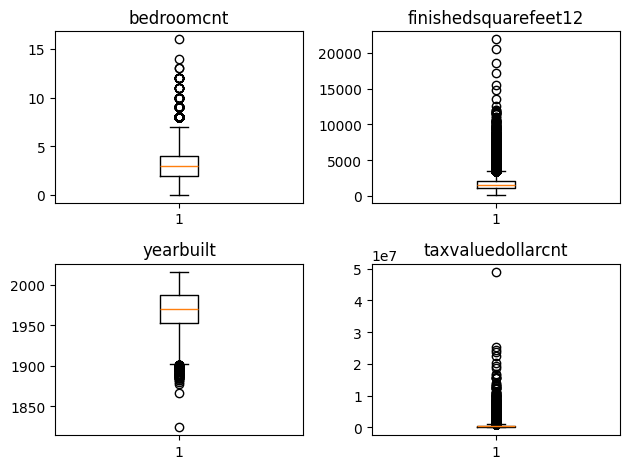

In [ ]:
# Boxplots to check outliers
for i, col in enumerate(selected_feature_target):
    plt.subplot(2, 2, i + 1)
    plt.boxplot(df[col].dropna())
    plt.title(col)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Property with number of bathrooms')

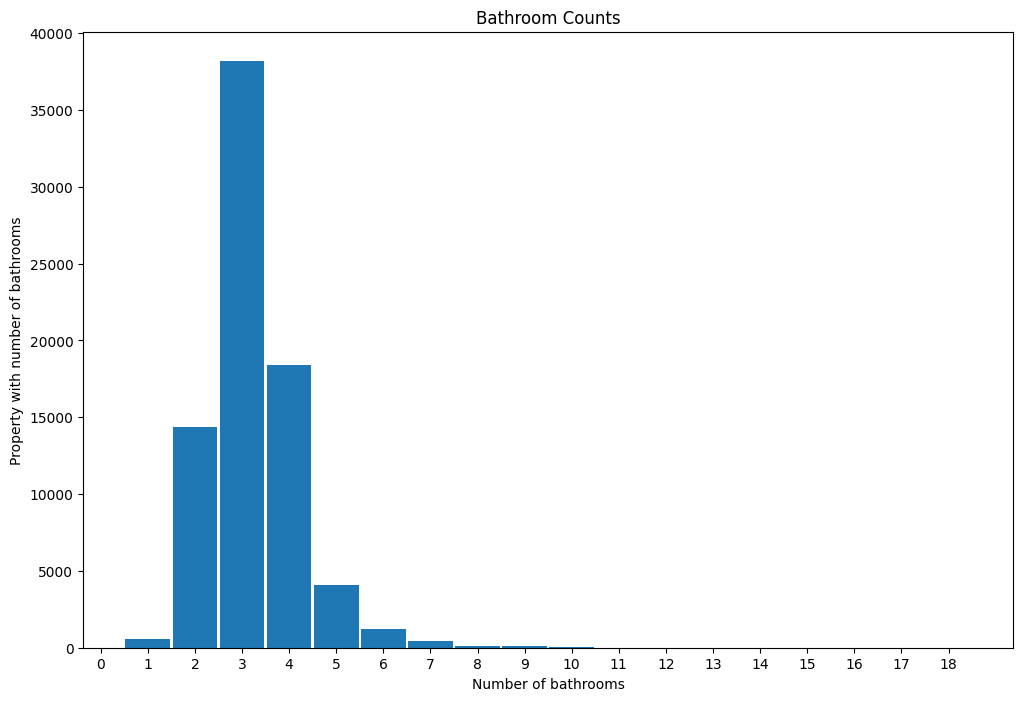

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(df['bathroomcnt'], bins = 18, align='right', rwidth=0.95)
plt.xticks(range(0,19))
plt.title('Bathroom Counts')
plt.xlabel('Number of bathrooms')
plt.ylabel('Property with number of bathrooms')


Text(0, 0.5, 'Property with number of bathrooms')

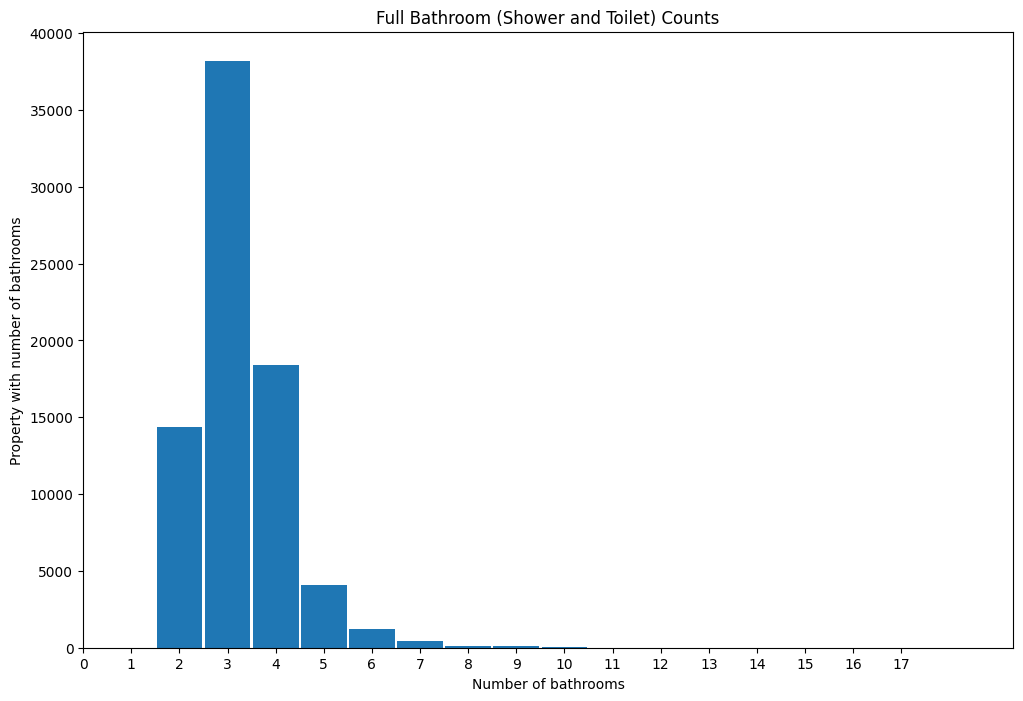

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(df['fullbathcnt'], bins=17, align='right', rwidth=0.95)
plt.xticks(range(0,18))
plt.title('Full Bathroom (Shower and Toilet) Counts')
plt.xlabel('Number of bathrooms')
plt.ylabel('Property with number of bathrooms')


In [ ]:
# There can be some missing values that can effect the full bathroom count.  For now my idea is that for any nan values in fullbath be equal to bathroomcounts or 0. (could also be no showers depending on property type)
# other than that, the distribution of both bath histograms are nearly identical with it being skewed to the left with some outliers surpassing 6-7+

Text(0, 0.5, 'Property with number of rooms')

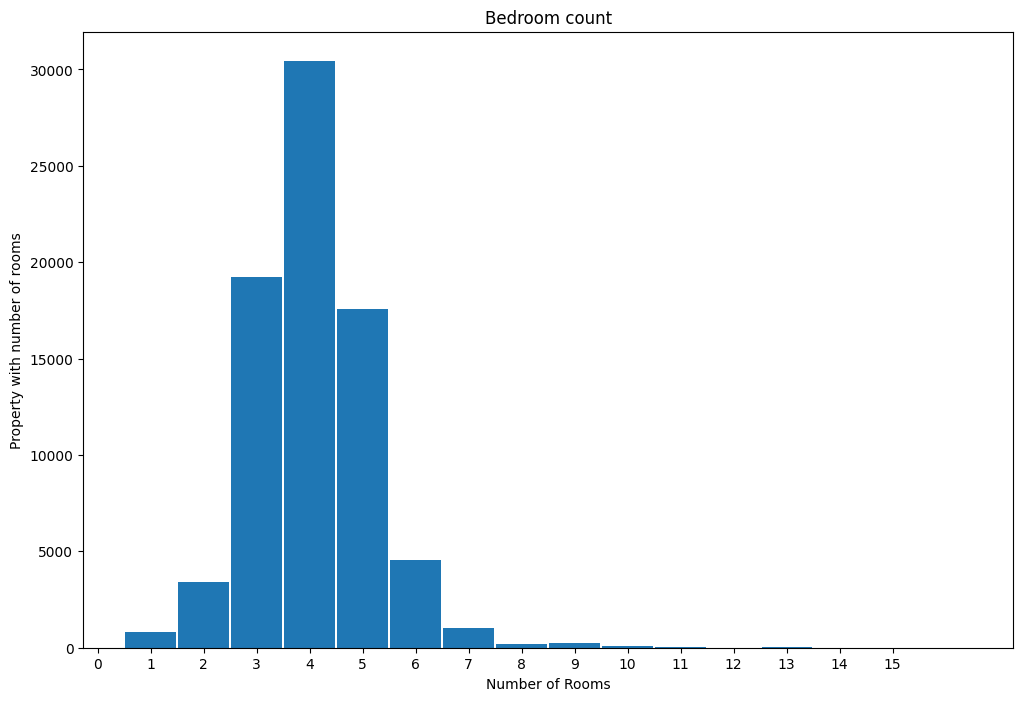

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(df['bedroomcnt'] , bins=16, align='right',rwidth=0.95)
plt.xticks(range(0,16))
plt.title('Bedroom count')
plt.xlabel('Number of Rooms')
plt.ylabel('Property with number of rooms')

In [ ]:
# Normally distributed at 4, with some outliers beyond 8. Overall nothing out of the ordinary

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


In [ ]:
# A majority of the histograms have some sort of outlier.  The graphs are skewed to a side and outliers on the other side.  Some of the ids only have one value.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task!

In [ ]:
df_clean = df.copy()
df_clean = df.drop(columns = ['fips','latitude','longitude','regionidneighborhood'])#'regionidcity','regionidcounty','regionidneighborhood','regionidzip'])
df_clean.drop(columns=['propertyzoningdesc','propertycountylandusecode','heatingorsystemtypeid','buildingqualitytypeid','parcelid'], inplace=True)
df_clean.drop(columns=['rawcensustractandblock','censustractandblock'], inplace=True)

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop.


Latitude and longitude features will not be used for regression and classifcation. Removing descriptions and any ids that have no evaluations on price or id types that have no relative information to impute. A census tract is a relatively small, permanent geographic area, often considered a neighborhood, with boundaries typically following visible features like roads or rivers, while a census block is the smallest geographic area for which the Census Bureau collects data,
usually bounded by streets or other visible features. I do not think it is used to evalutate property price

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully.

In [ ]:
#show_null_counts_features(df_clean)

df_keep = df_clean[['hashottuborspa','fireplacecnt','poolcnt','numberofstories','garagecarcnt','garagetotalsqft']]

In [ ]:
df_copy = df_clean.isnull().sum()
df_copy

drop_columns = df_copy[df_copy > 50000].keys()
df_clean.drop(columns = drop_columns, inplace=True)

df_main = pd.concat([df_clean,df_keep], axis=1)
show_null_counts_features(df_main)
df_main

The dataset contains 77613 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
hashottuborspa                 76074       98.02%   Categorical
fireplacecnt                   69324       89.32%   Numeric
poolcnt                        61439       79.16%   Numeric
numberofstories                60014       77.32%   Numeric
garagecarcnt                   52093       67.12%   Numeric
garagetotalsqft                52093       67.12%   Numeric
unitcnt                        26910       34.67%   Numeric
lotsizesquarefeet              8292        10.68%   Numeric
finishedsquarefeet12           3690        4.75%   Numeric
regionidcity                   1506        1.94%   Numeric
calculatedbathnbr              650         0.84%   Numeric
fullbathcnt                    650         0.84%   Numeric
yearbuilt                      304         0.39%   Numeric
calculatedfinishedsquarefeet   235         0.30%   Numeric
regioni

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,lotsizesquarefeet,propertylandusetypeid,regionidcity,regionidcounty,...,unitcnt,yearbuilt,assessmentyear,taxvaluedollarcnt,hashottuborspa,fireplacecnt,poolcnt,numberofstories,garagecarcnt,garagetotalsqft
0,3.5,4.0,3.5,3100.0,3100.0,3.0,4506.0,261.0,53571.0,1286.0,...,NaN,1998.0,2016.0,1023282.0,NaN,NaN,NaN,NaN,2.0,633.0
1,1.0,2.0,1.0,1465.0,1465.0,1.0,12647.0,261.0,13091.0,2061.0,...,NaN,1967.0,2016.0,464000.0,NaN,1.0,NaN,1.0,1.0,0.0
2,2.0,3.0,2.0,1243.0,1243.0,2.0,8432.0,261.0,21412.0,1286.0,...,NaN,1962.0,2016.0,564778.0,NaN,NaN,1.0,1.0,2.0,440.0
3,3.0,4.0,3.0,2376.0,2376.0,3.0,13038.0,261.0,396551.0,3101.0,...,1.0,1970.0,2016.0,145143.0,NaN,NaN,1.0,NaN,NaN,NaN
4,3.0,3.0,3.0,1312.0,1312.0,3.0,278581.0,266.0,12447.0,3101.0,...,1.0,1964.0,2016.0,119407.0,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,3.0,3.0,3.0,1741.0,1741.0,3.0,59487.0,266.0,12447.0,3101.0,...,1.0,1980.0,2016.0,379000.0,NaN,NaN,1.0,NaN,NaN,NaN
77609,2.0,2.0,2.0,1286.0,1286.0,2.0,47405.0,261.0,12447.0,3101.0,...,1.0,1940.0,2016.0,354621.0,NaN,NaN,NaN,NaN,NaN,NaN
77610,2.0,4.0,2.0,1612.0,1612.0,2.0,12105.0,261.0,27110.0,2061.0,...,NaN,1964.0,2016.0,67205.0,NaN,1.0,NaN,1.0,2.0,560.0
77611,1.0,3.0,1.0,1032.0,1032.0,1.0,5074.0,261.0,36502.0,3101.0,...,1.0,1954.0,2016.0,49546.0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_main[['bathroomcnt','bedroomcnt','roomcnt']]

,bathroomcnt,bedroomcnt,roomcnt
0,3.5,4.0,0.0
1,1.0,2.0,5.0
2,2.0,3.0,6.0
3,3.0,4.0,0.0
4,3.0,3.0,0.0
...,...,...,...
77608,3.0,3.0,0.0
77609,2.0,2.0,0.0
77610,2.0,4.0,7.0
77611,1.0,3.0,0.0


#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



I removed most of the features that had more than 50,000 nulls.  Those are hard to impute and could lead to inaccuracies when analysing the data.  The other property features that I kept were numeric, meaning that the null values could possibly be 0 so that can be fixed.  These features can also contribute to the price of the house.

### Part 3.C: Drop Problematic **samples**

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [ ]:
df_main['numberofstories'].unique()
df_main['roomcnt'].unique() # carbon nanotube sensors?? Not room count?

array([ 0.,  5.,  6.,  8.,  7., 11.,  3.,  4.,  9., 10., nan, 13., 12.,
        2., 14.,  1., 15.])

In [ ]:
df_main = df_main.drop(columns=['numberofstories'])

In [ ]:
df_main = df_main.dropna(subset=['taxvaluedollarcnt'])

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


I dropped the number of stories as null values cannot be 0, as 0 story building do not have any meaning to it. I dropped any rows that do not have any values in the target - taxvaluedollarcnt.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [ ]:
show_null_counts_features(df_main)

The dataset contains 77578 samples.

Feature Name                  # Nulls      Null %     Type
------------                  -------      ------     ----
hashottuborspa                 76039       98.02%   Categorical
fireplacecnt                   69289       89.32%   Numeric
poolcnt                        61405       79.15%   Numeric
garagecarcnt                   52059       67.11%   Numeric
garagetotalsqft                52059       67.11%   Numeric
unitcnt                        26875       34.64%   Numeric
lotsizesquarefeet              8258        10.64%   Numeric
finishedsquarefeet12           3656        4.71%   Numeric
regionidcity                   1472        1.90%   Numeric
calculatedbathnbr              616         0.79%   Numeric
fullbathcnt                    616         0.79%   Numeric
yearbuilt                      270         0.35%   Numeric
calculatedfinishedsquarefeet   201         0.26%   Numeric
regionidzip                    50          0.06%   Numeric


In [ ]:
#df_main['fireplacecnt'].unique()
df_main['fireplacecnt'] = df_main['fireplacecnt'].fillna(0)

In [ ]:
df_main['poolcnt'] = df_main['poolcnt'].fillna(0)

In [ ]:
#df_main['garagecarcnt'].unique() # there is already 0 counts, but i will do it anyways
df_main['garagecarcnt'] = df_main['garagecarcnt'].fillna(0)

In [ ]:
df_main[['garagecarcnt','garagetotalsqft']] # from the previous look at the null counts, garagecarcnt and garagetotalsqft have the same amount of null values, so i will assume NaN values are 0.
df_main['garagetotalsqft'] = df_main['garagetotalsqft'].fillna(0)

In [ ]:
df_main['unitcnt'] = df_main['unitcnt'].fillna(0)

In [ ]:
df_main[['bathroomcnt','fullbathcnt']] # full bath is bathroomcnt rounded down. if bathroomcnt is 0, then it will show NaN on fullbathcnt.  calculatedbathnbr is shared together with fullbath
#df_main[df['bathroomcnt'] == 0 ][['bathroomcnt','fullbathcnt']]
df_main[['fullbathcnt','calculatedbathnbr']] = df_main[['fullbathcnt','calculatedbathnbr']].fillna(0)

In [ ]:
df_main['yearbuilt'] = df_main['yearbuilt'].fillna(df_main['yearbuilt'].mode()[0]) # the distribution is normal, so i will use its mode

In [ ]:
df_main[['finishedsquarefeet12','lotsizesquarefeet','calculatedfinishedsquarefeet']] # finishedsquarefeet12 = calculatedfinishedsquarefeet
df_main['finishedsquarefeet12'] = df_main['finishedsquarefeet12'].fillna(df_main['calculatedfinishedsquarefeet'])

In [ ]:
# not sure what to do with lotsizesquarefeet
# i think median will be a good choice seeing how much it is skewed.
df_main[['finishedsquarefeet12','lotsizesquarefeet','calculatedfinishedsquarefeet']] = df_main[['finishedsquarefeet12','lotsizesquarefeet','calculatedfinishedsquarefeet']].fillna(df_main[['finishedsquarefeet12','lotsizesquarefeet','calculatedfinishedsquarefeet']].median())

In [ ]:
df_main[['regionidzip','regionidcity']]
#df_main.groupby('regionidcity')['regionidzip']
# city can be filled with mode
# zip can be filled with median
df_main[['regionidcity','regionidzip']] = df_main[['regionidcity','regionidzip']].astype(float)

df_main['regionidcity'] = df_main['regionidcity'].fillna(df_main['regionidcity'].mode())
df_main['regionidzip'] = df_main['regionidzip'].fillna(df_main['regionidzip'].median())


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary.

In [ ]:
df_main['hashottuborspa'] = df_main['hashottuborspa'].replace({True: 1, np.nan: 0})

<ipython-input-69-a4d1aeb30ddd>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_main['hashottuborspa'] = df_main['hashottuborspa'].replace({True: 1, np.nan: 0})


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project.

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well).
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments.

In [ ]:
import seaborn as sns

In [ ]:
sns.pairplot(df_main)

In [ ]:
sns.heatmap(df_main.corr(), cmap='RdBu')

In [ ]:
sns.heatmap(df_main.corr(), cmap='viridis')

In [ ]:
df_main.corr()['taxvaluedollarcnt'].sort_values(ascending=False)

In [ ]:
df_main.corr()

In [ ]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
#model = ols('regionidcounty ~ garagecarcnt', data=df_main).fit()
#anova_table = sm.stats.anova_lm(model)
#anova_table # if PR is less than 0.05, the value is significant.

In [ ]:
# Removing null city id's from the df_main
df_main = df_main[df_main['regionidcity'].isnull() == False]

In [ ]:
# computing the f-statistic between the features
from sklearn.feature_selection import f_regression

X = df_main.drop(columns=['taxvaluedollarcnt'])
y = df_main['taxvaluedollarcnt']

f_values, p_values = f_regression(X,y)

results = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'P-Value': p_values})
results.sort_values(by='P-Value', ascending=True)

In [ ]:
df_main.nunique().sort_values(ascending = True)

In [ ]:
# bar chart for f-statistic

In [ ]:
from sklearn.model_selection   import train_test_split, cross_val_score
from sklearn.linear_model      import LinearRegression,Ridge,Lasso
from sklearn.model_selection   import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics           import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing     import StandardScaler

In [ ]:
# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)

In [ ]:
# Forward Feature Selection

def forward_feature_selection(X, y, model,
                              scoring='neg_root_mean_squared_error',
                              cv=5,
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score

    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far

    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]

            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y,
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]

        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (RMSE): {current_score:.4f}")

        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()

        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score
    )


In [ ]:
# Backward Feature Selection

def backward_feature_selection(X, y, model,
                               scoring='neg_root_mean_squared_error',
                               cv=5,
                               tol=None,               # None = no delta cutoff
                                                       # use 0.0 for "no further improvements"
                                                       # and 1e-4 for "point of diminishing returns"
                               max_features=None,      # If None, remove features until only 1 remains
                                                       # Otherwise, stop when this many features remain
                               n_jobs=-1,
                               verbose=False
                              ):

    # Helper function to compute CV score using LinearRegression
    def cv_score(features):
        return -cross_val_score(model, X[features], y,
                                scoring=scoring, cv=cv,
                                n_jobs=n_jobs          ).mean()

    # Start with all features (using a list for easier manipulation)
    features_remaining = list(X.columns)

    # Compute initial CV score with the full feature set
    initial_score = cv_score(features_remaining)

    # Initialize tracking variables
    best_score        = initial_score                # Best (lowest) CV score observed so far
    best_feature_set  = features_remaining.copy()    # Feature set corresponding to best_score
    selected_features = ['NONE']                     # List to record the order in which features are removed
    best_scores       = [initial_score]              # List to record the CV score after each removal (starting with full set)

    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {np.around(initial_score, 4)}\n')

    # Determine the target number of features to keep:
    # For backward elimination, if max_features is None, we remove until 1 feature remains.
    target_feature_count = 1 if max_features is None else max_features

    prev_score = initial_score
    round_num = 1
    # Continue removing features until we reach the target count
    while len(features_remaining) > target_feature_count:
        if verbose:
            print(f'Round {round_num}:')

        # Initialize variables to track the best removal in this round
        lowest_score = float('inf')
        feature_to_remove = None
        best_new_features = None

        # Try removing each feature one at a time
        for feature in features_remaining:
            new_feature_set = features_remaining.copy()
            new_feature_set.remove(feature)
            new_score = cv_score(new_feature_set)
            if verbose:
                print('Trying removal of:',feature, np.around(new_score, 4))
            if new_score < lowest_score:
                lowest_score = new_score
                feature_to_remove = feature
                best_new_features = new_feature_set

        # Check if improvement is significant enough (if tol is set)
        if tol is not None and (prev_score - lowest_score) < tol:
            if verbose:
                print("\nStopping early due to minimal improvement.")
            break

        # Update the best score and feature set if current removal improves performance
        if lowest_score < best_score:
            best_score = lowest_score
            best_feature_set = best_new_features.copy()

        # Update trackers for this round
        prev_score = lowest_score
        features_remaining = best_new_features
        selected_features.append(feature_to_remove)
        best_scores.append(lowest_score)

        if verbose:
            print(f'\nRemoving {feature_to_remove}:  CV score (MSE) {np.around(lowest_score, 4)}\n')
        round_num += 1

    return (
        selected_features,      # Order in which features were removed
        best_scores,            # CV scores after each removal step
        best_feature_set,       # Feature set that achieved the best CV score
        best_score              # Best (lowest) CV score
    )


In [ ]:
# Your code here:  Run Forward Feature Selection, plot the results, and print out the Best Feature Set and the Best CV Score found.
model = LinearRegression()

selected_features, best_scores, best_feature_set, best_score = forward_feature_selection(X_train, y_train, model, verbose=False)

# Plotting the results

index = np.argmax(np.array(selected_features) == best_feature_set[-1])

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_scores) + 1), best_scores, marker='.')
plt.plot([index+1],best_score,marker='x',color='red')
plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=60, ha='right', fontsize=6)
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print the best subset and score
print(f"Best Features: {best_feature_set}")
print(f"Best CV Score: {best_score:.4f}")

In [ ]:
# Your code here:  Run Backward Feature Selection, plot the results, and print out the Best Feature Set and the Best CV RMSE Score found.
model_2 = LinearRegression()

selected_features_2, best_scores_2, best_feature_set_2, best_score_2 = backward_feature_selection(X_train, y_train, model=model_2, verbose=False)

# Plot the results
plt.figure(figsize=(10, 6))
plt.title('Backward Feature Selection and CV Scores')
plt.plot(range(1, len(best_scores_2) + 1), best_scores_2, marker='.')
index = np.argmin(best_scores_2)
plt.plot([index + 1], best_scores_2[index], marker='x', color='red')
plt.xticks(range(1, len(selected_features_2) + 1), selected_features_2, rotation=40, ha='right', fontsize=8)
plt.xlabel('Features Removed')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print minimum cv score

print("Best feature set:", best_feature_set_2)
print("CV score (RMSE):",np.around(best_score_2,4))

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships.
 How do the different methods for seeing relationships compare? Do they agree or disagree?



There are lots of highly correlated relationships with features describing quantity of bedrooms, bathrooms, and sqaurefootaage of the property. Mind you these are relationsips with one another and not the target value. Other interesting relationships to note were roomcnt, garagecarcnt, cnd garagetotalsqft. These tree features above had a high negative correlation with the regionidcounty feature

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis.
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends.

In [ ]:
plt.scatter(df_main['bedroomcnt'],df_main['bathroomcnt'], alpha = 0.5)
plt.title('Bathroom and Bedroom Count')
plt.xlabel('Bedrooms')
plt.ylabel('Bathrooms')

In [ ]:
# garagecarcnt vs regionidcounty
plt.scatter(df_main['regionidcounty'],df_main['garagecarcnt'], alpha = 0.5)
# i think the correlation does not mean anything.  Need id to be encoded

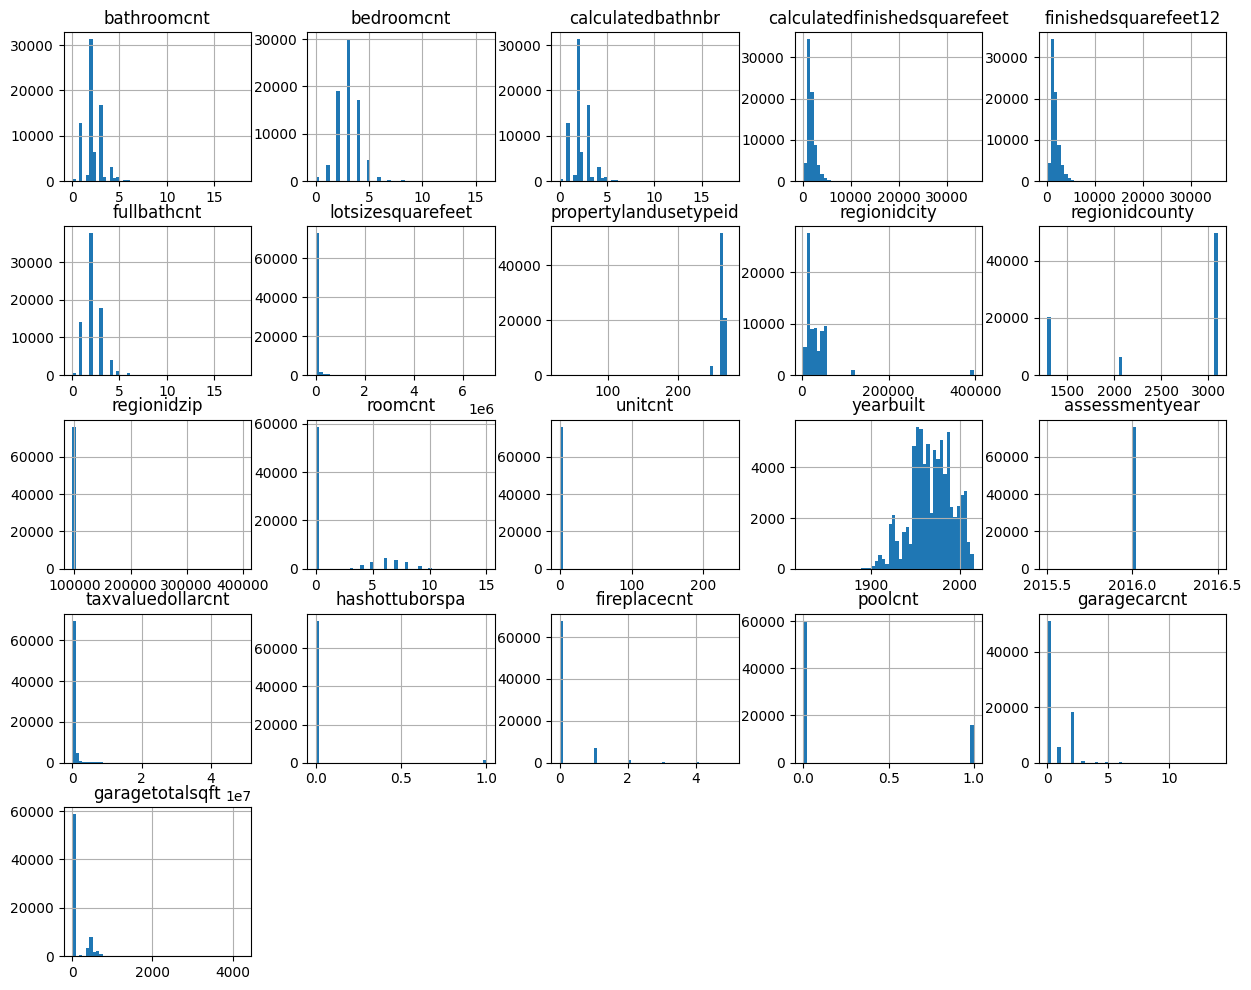

In [120]:
df_main.hist(figsize=(15,12), bins=50)
None

<Axes: >

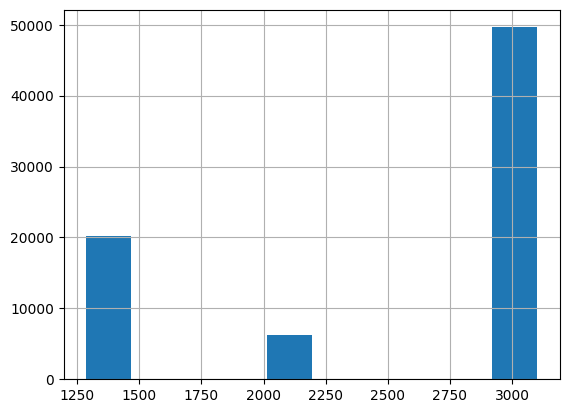

In [121]:
df_main['regionidcounty'].hist()

In [123]:
df_main.nunique()

,0
bathroomcnt,22
bedroomcnt,16
calculatedbathnbr,22
calculatedfinishedsquarefeet,4941
finishedsquarefeet12,4941
fullbathcnt,14
lotsizesquarefeet,18550
propertylandusetypeid,13
regionidcity,175
regionidcounty,3


#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset.
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection).
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary.

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question.

In [ ]:
#fig, axes = plt.subplots(1, 2, figsize=(10,6))
#axes[0].boxplot(df_main['lotsizesquarefeet'])
#axes[0].set_title('lotsizesquarefeet')
#df_transform = df_main.copy()

# log for lotsize,
#df_transform['lotsizesquarefeet_log'] = np.log1p(df_transform['lotsizesquarefeet'])
#axes[1].boxplot(df_transform['lotsizesquarefeet_log'])
#axes[1].set_title('log lotsizesquarefeet')

def log_transformation(df, column):
  fig, axes = plt.subplots(1, 2, figsize=(10,6))

  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  #df_transform = df_main.copy()


  axes[1].boxplot(np.log(df[column]))
  axes[1].set_title(f'log {column}')

log_transformation(df_main, 'lotsizesquarefeet')
# We can see that 50% of the data fall into a small range, meaning that alot of property are similar in size
# but then there are multiple properties that do not fall into the box.  The outliers shown vary in size

In [ ]:
# polynomial for calculatedbathnbr
def polynomial_transform(df, column, degree):
  fig, axes = plt.subplots(1, 2, figsize=(10,6))
  axes[0].boxplot(df[column])
  axes[0].set_title(column)
  axes[1].boxplot(df[column]**degree)
  axes[1].set_title(f'poly transform of {column}')

polynomial_transform(df_main, 'calculatedbathnbr', .5)

<ipython-input-128-c54d67c0da62>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column}_standardized'] = scaler.fit_transform(df[[column]])


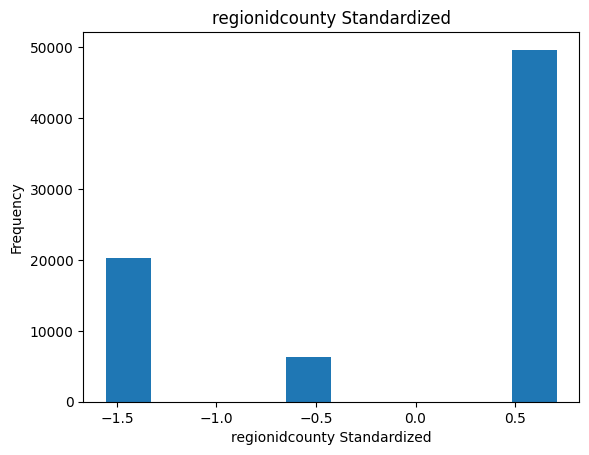

In [128]:
# encode for regionidcounty : 3 values # i think encoding id values is not the best because we do not know what the ids means.
def standardized(df, column):
  scaler = StandardScaler()
  df[f'{column}_standardized'] = scaler.fit_transform(df[[column]])
  plt.hist(df[f'{column}_standardized'])
  plt.title(f'{column} Standardized')
  plt.xlabel(f'{column} Standardized')
  plt.ylabel('Frequency')

standardized(df_main, 'regionidcounty')

In [132]:
def OneHot(df, column):
  coder = OneHotEncoder()
  df[f'{column}_encoded'] = coder.fit_transform(df[[column]])
  plt.hist(df[f'{column}_encoded'])
  plt.title(f'{column} Encoded')
  plt.xlabel(f'{column} Encoded')
  plt.ylabel('Frequency')

OneHot(df_main, 'regionidcounty')

TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed.


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

